In [88]:
# load env
from dotenv import load_dotenv
import os
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["PINECODE_API_KEY"]=os.getenv("PINECODE_API_KEY")
os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")
os.environ["HUGGINGFACE_API_KEY"]=os.getenv("HUGGINGFACE_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"]=os.getenv("LANGCHAIN_TRACING_V2")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [89]:
# pydantic model
from pydantic import BaseModel,Field

class TopicSelector(BaseModel):
    topic:str=Field(description="topic name")
    reason_for_selection:str=Field(description="topic selection reason")        



In [90]:
# llm model using reasoning model of google
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

In [91]:
# using hugging face embeddings
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
vector_dimension=len(embeddings.embed_query("hi"))
vector_dimension

768

In [92]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader
# load document pages
loader=DirectoryLoader("./data",glob="./*.txt",loader_cls=TextLoader,show_progress=True)
pages = loader.load()
len(pages)

# split pages to chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

chunks=text_splitter.split_documents(pages);

len(chunks)


100%|██████████| 1/1 [00:00<00:00, 1677.05it/s]


55

In [93]:
# using chromdb as vector store
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
# initialized the vector db
vector_store = Chroma(
    collection_name="usa-gdp-data",
    embedding_function=embeddings
)

In [94]:
# save documents to vector db
vector_store.add_documents(chunks)

['ff1a4e9d-8a65-4b04-9d1f-6320ec40e8b5',
 '56d44110-bff7-42a5-814a-a5183af54d8d',
 '0fdebb87-229a-4646-9b49-e7f94c1dd312',
 'db3f03fb-4efa-47ed-a0c3-cd2333773150',
 '07704e77-8e3e-49c8-9bb3-e717081bf77a',
 '0bb82a7c-9154-4b0b-bd0d-0d326224fc1e',
 'd6779d4d-56e1-48b0-8a15-609bdef0606a',
 'c46edc48-4fce-4e5d-9ead-7c3a1b0f19d4',
 'd83799bc-6287-45ad-bbc2-0a5959338dbe',
 '343ad718-a230-4baa-854f-54fae4efbe0b',
 '16595bf2-7528-459b-909d-6ce059a14d00',
 '0655b3de-c74f-4cf9-b291-502c731772a2',
 '8526a336-3dea-40f7-9999-2e731c6cf379',
 'e01e9a45-6ab2-416e-b9b8-6d5c1cda9503',
 'ab227c1f-95ac-4e20-8e49-b42fc9e26507',
 '1498b22b-cbc8-48b6-bbff-06f94936383b',
 '3d9a6e8b-f0ae-4062-81e7-caef4001461e',
 'cd140be9-9625-42d6-bf79-7e81fbf1fdc6',
 '11d7338d-6518-44ce-aa29-b1686763a323',
 '08c8b452-fdc4-496b-a15a-ed4847bd90c0',
 'e9251818-fe30-40e0-919f-b14d543075cb',
 '31e56de8-d280-4e64-bdb8-3fb0bef58b3d',
 '3d594e7e-69a2-4302-a15a-acdd1b30303b',
 '9db997e9-580a-4ca5-800d-35876806ce50',
 '88e29e1c-b2c0-

In [95]:
# chromadb as retriever
data_retriever=vector_store.as_retriever(search_kwargs={"k":3})
data_retriever.invoke("industrial growth of usa?")

[Document(id='d2222135-e478-42ca-91dc-4a82a84668ad', metadata={'source': 'data/usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'),
 Document(id='bad2b88b-8390-4c97-b5ac-60a31183ef0f', metadata={'source': 'data/usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'),
 Document(id='ff1a4e9d-8a65-4b04-9d1f-6320ec40e8b5', metadata={'source': 'data/usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy')]

In [96]:
# create custom state for langgraph
import operator
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],operator.add]

In [97]:
# supervisor 
from langchain_core.output_parsers import StrOutputParser
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
supervisor_parser=PydanticOutputParser(pydantic_object=TopicSelector)
def supervisor(state:AgentState):
    print("## supervisor ##")
    question=state["messages"][-1]
    print(f"## supervisor ## question : {question}")
    template="""
    Your task is to classify the given user query into one of the following categories: [USA,Not Related].
    Only respond with the category name and nothing else.
    
    User query: {question}
    {format_instructions}
    """
    
    prompt=PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": supervisor_parser.get_format_instructions()}
    )
    
    chain=prompt|model|supervisor_parser
    
    response=chain.invoke({"question":question})
    
    print(f"## supervisor ## response : {response}")
    
    return {"messages":[response.topic]}

In [115]:
# router 
def router(state:AgentState):
    print("## router ##")
    last_message=state["messages"][-1]
    print(f"## router ## last_message : {last_message}")
    if "usa" in last_message.lower():
        return "rag call"
    else :
        return "llm with tool"

In [111]:
# rag call
def rag_call(state:AgentState):
    print("## rag_call ##")
    question = state["messages"][0]
    print(f"## rag_call ## question : {question}")
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

In [112]:
# web search tavily
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_api_key=os.getenv("TAVILY_API_KEY")

tavily_tool=TavilySearchResults(travily_api_key=tavily_api_key)

tavily_tool.run("who is winner of 2025 IPL?")


[{'title': 'IPL 2025 results: Get all cricket scores, points table, standings and ...',
  'url': 'https://www.olympics.com/en/news/ipl-2025-results-cricket-scores-standings-points-table-net-run-rate',
  'content': 'The [**IPL 2025**](https://www.olympics.com/en/news/indian-premier-league-ipl-2025-schedule-match-list) concluded on June 3 with Royal Challengers Bengaluru defeating Punjab Kings in the final to lift their maiden title.\n\nThis was the 18th edition of the [**Indian Premier League**](https://www.olympics.com/en/news/indian-premier-league-ipl-winners-list-champions) - the world’s most lucrative franchise-based T20 league.\n\nRCB became the eighth team to win the IPL trophy. [...] The top two teams - PBKS and RCB - battled it out in Qualifier 1, with the Royal Challengers winning it to earn a direct ticket to the final.\n\nHowever, PBKS ended up joining RCB in the finale after defeating MI, who defeated GT in the Eliminator.\n\nOverall, MI and CSK are the most successful teams

In [114]:
from langchain_openai import ChatOpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
# llm call with tools integration
def llm_call(state:AgentState):
    print("## llm_call ##")
    question = state["messages"][0]
    print(f"## llm_call ## question : {question}")

    agent = initialize_agent(
        tools=[tavily_tool],
        llm=model,
        agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
        verbose=True
    )
    
    prompt = PromptTemplate(
    template=(
        "Answer the following question using a tool if needed.\n"
        "You must respond in this format:\n"
        "Thought: ...\n"
        "Action: <tool name>\n"
        "Action Input: <input for the tool>\n"
        "OR\n"
        "Thought: ...\n"
        "Final Answer: <answer to the user>\n"
        "\n"
        "Question: {question}"
    ),
    input_variables=["question"]
    )
    

    chain = prompt | agent | StrOutputParser()
    response = chain.invoke({"question": question})
    return {"messages": [response['output']]}

In [102]:
prompt = PromptTemplate(
    template=(
        "Answer the following question using a tool if needed.\n"
        "You must respond in this format:\n"
        "Thought: ...\n"
        "Action: <tool name>\n"
        "Action Input: <input for the tool>\n"
        "OR\n"
        "Thought: ...\n"
        "Final Answer: <answer to the user>\n"
        "\n"
        "Question: {question}"
    ),
    input_variables=["question"]
)

agent = initialize_agent(
    tools=[tavily_tool],
    llm=model,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

question = "Tell me about GDP of poorest economy"
chain = prompt | agent | StrOutputParser()
response = chain.invoke({"question": question})
response['output']




> Entering new AgentExecutor chain...
Thought: I need to find out which is the poorest economy and then find its GDP.
Action: tavily_search_results_json
Action Input: "poorest economy in the world GDP"
Observation: [{'title': 'Poorest Countries in the World 2025 - World Population Review', 'url': 'https://worldpopulationreview.com/country-rankings/poorest-countries-in-the-world', 'content': "Economics > Poorest Countries in the World 2025. Poorest Countries in the ... Burundi is the world's poorest country, with a GDP per capita, PPP of $950.90.", 'score': 0.8361405}, {'title': 'Top 10 Poorest Countries In The World By GDP Per Capita [2025]', 'url': 'https://www.forbesindia.com/article/explainers/poorest-countries-in-the-world/87529/1', 'content': "As we now know the per capita income of these companies, let's explore the reasons that have led to these bottom ten economies being categorised as the world's poorest.\n\n### South Sudan\n\n*   GDP: $4 billion\n*   Population: [11,205,383

'Several sources indicate that Burundi and South Sudan are among the poorest economies in the world.\n\n*   **Burundi:** The GDP in 2023 was approximately $2.64 billion USD (World Bank data). Other sources estimate higher values when considering Purchasing Power Parity (PPP).\n*   **South Sudan:** The GDP in 2023 was approximately $7.0 billion USD. However, this figure can vary depending on the source and year.'

In [103]:
# validation or guard_rail
def guard_rail(state:AgentState):
    print("## guard_rail ##")
    last_message=state["messages"][-1]
    print(f"## guard_rail ## last_message : {last_message}")
    return {"messages":["pass"]}

from langgraph.graph import StateGraph, START, END    
# guard_router
def guard_router(state:AgentState):
    print("## guard_router ##")
    last_message=state["messages"][-1]
    print(f"## guard_router ## last_message : {last_message}")
    if "pass" in last_message.lower():
        return END
    else :
        return "supervisor"

In [116]:
# langgraph
from langgraph.graph import StateGraph, START, END

work_flow=StateGraph(AgentState)

work_flow.set_entry_point("supervisor")

work_flow.add_node("supervisor",supervisor)

work_flow.add_node("llm with tool",llm_call)

work_flow.add_node("rag",rag_call)

work_flow.add_node("guard_rail",guard_rail)

work_flow.add_conditional_edges(
    "supervisor",
    router,
    {
        "llm with tool" : "llm with tool",
        "rag call" : "rag"
    }
)

work_flow.add_edge("rag","guard_rail")

work_flow.add_edge("llm with tool","guard_rail")

work_flow.add_edge("guard_rail", END)

work_flow.add_conditional_edges(
    "guard_rail",
    guard_router,
    {
        "pass" : END,
        "fail" : "supervisor",
          END  : END 
    }
)


In [117]:
# compile graph
app = work_flow.compile()

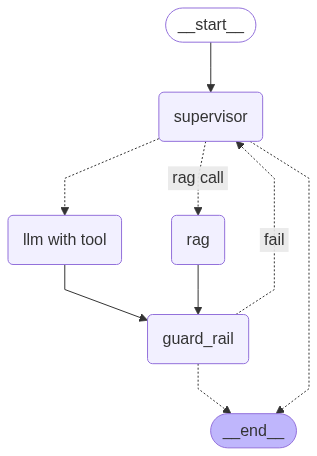

In [118]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [119]:
# run sample app
state={"messages":["can you tell me the industrial growth of world's most poor economy?"]}
result=app.invoke(state)
result


## supervisor ##
## supervisor ## question : can you tell me the industrial growth of world's most poor economy?
## supervisor ## response : topic='Not Related' reason_for_selection="The query is about the industrial growth of the world's poorest economy, which is not related to the USA."
## router ##
## router ## last_message : Not Related
## llm_call ##
## llm_call ## question : can you tell me the industrial growth of world's most poor economy?


> Entering new AgentExecutor chain...
Thought: I need to find information about the industrial growth of the world's poorest economy. I will use a search engine to find this information.
Action: tavily_search_results_json
Action Input: "industrial growth poorest economy world"
Observation: [{'title': '[PDF] Industrial development and economic growth - the United Nations', 'url': 'https://www.un.org/esa/sustdev/publications/industrial_development/3_1.pdf', 'content': '295 Industrial development and economic growth: Implications for poverty r

{'messages': ["can you tell me the industrial growth of world's most poor economy?",
  'Not Related',
  "I am unable to provide a specific industrial growth figure for the world's poorest economy based on the provided search results. The results discuss factors affecting economic growth in poor countries, but do not offer the specific data requested.",
  'pass']}